In [56]:
import os
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [57]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1


In [3]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
DATA_FILE = 'data/OxCGRT_latest.csv'

# Download the data set
data = requests.get(DATA_URL)

# Persist the data set locally in order to use it after submission to make predictions,
# as the sandbox won't have access to the internet anymore.
if not os.path.exists('data'):
    os.mkdir('data')
open(DATA_FILE, 'wb').write(data.content)

20647558

In [4]:
NPI_COLUMNS = ['C1_School closing',
               'C2_Workplace closing',
               'C3_Cancel public events',
               'C4_Restrictions on gatherings',
               'C5_Close public transport',
               'C6_Stay at home requirements',
               'C7_Restrictions on internal movement',
               'C8_International travel controls',
               'H1_Public information campaigns',
               'H2_Testing policy',
               'H3_Contact tracing',
               'H6_Facial Coverings']

In [116]:
NPIS_INPUT_FILE = "../../../validation/data/2020-12-16_historical_ip.csv"
start_date = "2020-11-27"
end_date = "2020-12-10"

In [117]:
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
df = pd.read_csv(DATA_URL,
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [12]:
new_df = df[['CountryName', 'RegionName', 'Date'] + NPI_COLUMNS]

In [13]:
new_df.to_csv('2020-12-16_historical_ip.csv', index=False)

## Baseline LSTM

In [7]:
# Reload the module to get the latest changes
import xprize_original_predictor
from importlib import reload
reload(xprize_original_predictor)
from xprize_original_predictor import XPrizePredictor

In [8]:
model_weights_file = "models/original_model.h5"
predictor = XPrizePredictor(model_weights_file, DATA_FILE)

In [9]:
%%time
preds_df = predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

CPU times: user 14min 51s, sys: 3.34 s, total: 14min 54s
Wall time: 14min 52s


## Use Prediction Ratio to sort countries to use for training

In [73]:
model_weights_pred_ratio_file = "models/original_model_prediction_ratio.h5"
predictor = XPrizePredictor(model_weights_pred_ratio_file, DATA_FILE)

In [74]:
%%time
preds_ratio_df = predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

CPU times: user 1min, sys: 1.42 s, total: 1min 1s
Wall time: 57 s


## Initialize model with the date before start date

In [108]:
# Reload the module to get the latest changes
import xprize_predictor_copy
from importlib import reload
reload(xprize_predictor_copy)
from xprize_predictor_copy import XPrizePredictor

In [109]:
model_weights_pred_ratio_file = "models/test_robojudge_2.h5"
better_predictor = XPrizePredictor(model_weights_pred_ratio_file, DATA_FILE)

In [110]:
%%time
init_preds_ratio_df = better_predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

CPU times: user 25.3 s, sys: 561 ms, total: 25.8 s
Wall time: 24.2 s


## Don't Shuffle

In [ ]:
no_shuffle = "models/no_shuffle.h5"
predictor = XPrizePredictor(no_shuffle, DATA_FILE)

In [ ]:
%%time
no_shuffle_df = predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

## More training countries + no shuffle

In [ ]:
more_training = "models/14_day_more_data.h5"
predictor = XPrizePredictor(more_training, DATA_FILE)

In [ ]:
%%time
more_training_df = predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

## More training countries, shuffle, 14 day window, 14 test days, 30 lookback

In [ ]:
longer = "models/14_day_window_30_lookback.h5"
predictor = XPrizePredictor(longer, DATA_FILE)

In [ ]:
%%time
longer_df = predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

## Dropout

In [ ]:
dropout = "models/dropout.h5"
predictor = XPrizePredictor(dropout, DATA_FILE)

In [ ]:
%%time
dropout_df = predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

## Baseline Lasso

In [58]:
import xprize_linear_predictor
from importlib import reload
reload(xprize_linear_predictor)
from xprize_linear_predictor import XPrizeLinearPredictor

In [59]:
predictor = XPrizeLinearPredictor("../linear/models/model.pkl", DATA_FILE)

In [60]:
%%time
preds_linear_df = predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

CPU times: user 4.75 s, sys: 20 ms, total: 4.77 s
Wall time: 4.77 s


## Lasso CV

In [61]:
predictor = XPrizeLinearPredictor("../linear/models/model_cv.pkl", DATA_FILE)

In [62]:
%%time
preds_lasso_cv_df = predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

CPU times: user 5.13 s, sys: 11.8 ms, total: 5.14 s
Wall time: 5.15 s


## Bayesian Ridge

In [63]:
predictor = XPrizeLinearPredictor("../linear/models/model_bayesian.pkl", DATA_FILE)

In [64]:
%%time
preds_bayesian_ridge_df = predictor.predict(start_date, end_date, NPIS_INPUT_FILE)

CPU times: user 5.16 s, sys: 11.9 ms, total: 5.17 s
Wall time: 5.18 s


## Actual Values

In [118]:
df["GeoID"] = np.where(df["RegionName"].isnull(),
                                      df["CountryName"],
                                      df["CountryName"] + ' / ' + df["RegionName"])
df["DailyChangeConfirmedCases"] = df.groupby(["GeoID"]).ConfirmedCases.diff().fillna(0)
date_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [128]:
country_name = "United States"
region_name = "California"
geo_id = country_name if region_name is None else country_name + ' / ' + region_name 

In [129]:
true_df = date_df[(date_df.GeoID == geo_id)]
y_true = true_df.DailyChangeConfirmedCases.values
labels = pd.to_datetime(true_df.Date.map(str),format="%Y-%m-%d").values

In [130]:
predictions = {
    # "Baseline LSTM": preds_df,
    # "Prediction Ratio Sorting LSTM": preds_ratio_df,
    "Initialized LSTM": init_preds_ratio_df,
    # "All above + no shuffle LSTM": no_shuffle_df,
    # "All above + more training data LSTM": more_training_df,
    # "14 test, 14 window, 30 lookback, more training LSTM": longer_df,
    # "Dropout LSTM": dropout_df,
    # "Baseline Lasso": preds_linear_df,
    # "Lasso CV": preds_lasso_cv_df,
    # "Bayesian Ridge": preds_bayesian_ridge_df,
}

        CountryName  RegionName       Date  PredictedDailyNewCases  \
1414  United States  California 2020-11-27            18992.005397   
1415  United States  California 2020-11-28            14282.254608   
1416  United States  California 2020-11-29            15607.628187   
1417  United States  California 2020-11-30            18906.429005   
1418  United States  California 2020-12-01            16820.313406   

                           GeoID  
1414  United States / California  
1415  United States / California  
1416  United States / California  
1417  United States / California  
1418  United States / California  


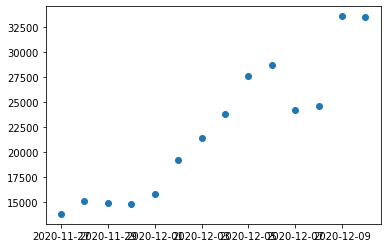

In [131]:
plt.scatter(labels, y_true)
for name, pred_df in predictions.items():
    y_pred_df = pred_df[(pred_df['Date'] >= start_date) & (pred_df['Date'] <= end_date)]
    y_pred_df["GeoID"] = np.where(y_pred_df["RegionName"].isnull(),
                                      y_pred_df["CountryName"],
                                      y_pred_df["CountryName"] + ' / ' + y_pred_df["RegionName"])
    y_pred = y_pred_df[(y_pred_df.GeoID == geo_id)]
    plt.plot(labels, y_pred.PredictedDailyNewCases.values, label=name)
    print(y_pred)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

## Calculate MAE

In [106]:
full_df = df[(df["Date"] <= '2020-05-20')]
gdf = full_df.groupby('GeoID')['ConfirmedDeaths'].agg(['max', 'count']).sort_values(by='max', ascending=False)
filtered_gdf = gdf[gdf["count"] > 21]
geos = list(filtered_gdf.head(20).index)
true_date_df = date_df[(date_df["GeoID"].isin(geos))]
for name, pred_df in predictions.items():
    pred_df["GeoID"] = np.where(pred_df["RegionName"].isnull(),
                                      pred_df["CountryName"],
                                      pred_df["CountryName"] + ' / ' + y_pred_df["RegionName"])
    test_geos_df = pred_df[(pred_df["GeoID"].isin(geos))]
    y_pred_df = test_geos_df[(test_geos_df['Date'] >= start_date) & (test_geos_df['Date'] <= end_date)]
    y_pred_values = y_pred_df.PredictedDailyNewCases.values
    
    merged_df = pd.merge(true_date_df, y_pred_df, on=["Date", "GeoID"])
    mae = np.sum(np.abs(merged_df.DailyChangeConfirmedCases.values - merged_df.PredictedDailyNewCases.values))
    print(f"{name}: {mae}") 

Initialized LSTM: 2032651.451797785
